---
title: Personalized Prediction Correlations for  868 rn7 genes
date: 9/1/23
author: Sabrina Mi
format:
  html:
    code-fold: true
---

We ran the personalized Enformer pipeline 868 genes for high variation in Br rats and number of eQTLs. There are too many predictions to concatenate iteratively, so I wrote [collect_predictions.py](collect_predictions.py) to parallelize in a submitted job. 

Note: This script appends predictions to the h5 in parallel, I first initialized the h5 file with individuals list to be paired with all gene expression datasets.

In [18]:
import h5py
import pandas as pd
project_dir = "/home/s1mi/Br_predictions/personalized_Br_selected_genes"

obs_gene_expr = pd.read_csv("/home/s1mi/enformer_rat_data/expression_data/Brain.rn7.expr.tpm.bed", sep="\t", nrows=1)
with h5py.File(f"{project_dir}/selected_genes_mouse_and_human_predictions.h5", "w") as file:
    file.attrs["index"] = obs_gene_expr.columns.to_list()[4:]



After my parsl job was stuck in the queue for two days, I decided to forgo parsl and append the predictions from the login node. This took many interrupted attempts, but was sadly the better option. The non-parallelized code is below:

In [ ]:
#### LIBRARIES AND DEFINITIONS
import pandas as pd
import numpy as np
import h5py
project_dir = "/grand/TFXcan/imlab/users/sabrina/Br_predictions/predictions_folder/personalized_Br_selected_genes"
predictions_dir = f"{project_dir}/predictions_2023-09-02/enformer_predictions"
obs_gene_expr = pd.read_csv("/home/s1mi/enformer_rat_data/expression_data/Brain.rn7.expr.tpm.bed", sep="\t", header=0, index_col='gene_id')
annot_df = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/rn7.gene.txt", sep="\t", header= 0, index_col='geneId')
#### GET LIST OF GENES
with open(f"gene_list.txt", "r") as file:
    gene_list = file.read().splitlines()
print(len(gene_list), "genes with enformer predictions")
#### JOIN WITH ENFORMER PREDICTIONS FUNCTION
def collect_predictions(gene):
    with h5py.File(f"{project_dir}/selected_genes_mouse_and_human_predictions.h5", "a") as output_file:
        if gene not in output_file.keys():
            ### INITIALIZE EXPRESSION MATRIX WITH OBSERVED DATA
            expr_df = pd.DataFrame({"observed": obs_gene_expr.loc[gene][3:].astype("float32")})    

            ### READ PREDICTIONS
            gene_annot = annot_df.loc[gene]
            interval = f"chr{gene_annot['chromosome']}_{gene_annot['tss']}_{gene_annot['tss']}"
            human_predicted = []
            mouse_predicted = []
            for individual in expr_df.index:
                with h5py.File(f"{predictions_dir}/{individual}/haplotype0/{interval}_predictions.h5", "r") as input_file:
                    human_prediction = input_file["human"][446:450, 4980]
                    mouse_prediction = input_file["mouse"][446:450, 1300]
                    human_predicted.append(np.average(human_prediction))
                    mouse_predicted.append(np.average(mouse_prediction))
            
            ### JOIN IN DATAFRAME
            expr_df["human predicted"] = human_predicted
            expr_df["mouse predicted"] = mouse_predicted
            ### WRITE TO h5
            output_file[gene] = expr_df
#### JOIN CONCURRENTLY ACROSS GENES
for gene in gene_list:
    collect_predictions(gene)
print("Finished writing expression matrices for", len(gene_list), "genes")

## Read Processed Predictions

In [7]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
colors = sns.color_palette("pastel")
project_dir = "/grand/TFXcan/imlab/users/sabrina/Br_predictions/predictions_folder/personalized_Br_selected_genes"
with open(f"gene_list.txt", "r") as file:
    gene_list = file.read().splitlines()
expr_dict = {}
with h5py.File(f"{project_dir}/selected_genes_mouse_and_human_predictions.h5", "r") as file:
    index = file.attrs["index"]
    for gene in file.keys():
        matrix = file[gene][:]
        expr_dict[gene] = pd.DataFrame(matrix, index = index, columns = ["observed", "human predicted", "mouse predicted"])

In [2]:
observed_matrix = pd.DataFrame(columns=gene_list)
human_predicted_matrix = pd.DataFrame(columns=gene_list)
mouse_predicted_matrix = pd.DataFrame(columns=gene_list)
### dataframes for haky
for gene in gene_list:
    observed_matrix[gene] = expr_dict[gene]['observed']
    human_predicted_matrix[gene] = expr_dict[gene]['human predicted']
    mouse_predicted_matrix[gene] = expr_dict[gene]['mouse predicted']
            

In [41]:
observed_matrix.shape

(340, 868)

In [11]:
observed_matrix.to_csv("/home/s1mi/enformer_rat_data/output/Br_observed_expression.csv")
human_predicted_matrix.to_csv("/home/s1mi/enformer_rat_data/output/Br_human_predicted_expression.csv")
mouse_predicted_matrix.to_csv("/home/s1mi/enformer_rat_data/output/Br_mouse_predicted_expression.csv")

In [3]:
pearson_corr_by_gene = pd.DataFrame(columns = ["human", "mouse"], index = gene_list)
pearson_pval_by_gene = pd.DataFrame(columns = ["human", "mouse"], index = gene_list)
for gene in gene_list:
    human_corr, human_pval = stats.pearsonr(expr_dict[gene]["observed"], expr_dict[gene]["human predicted"])
    mouse_corr, mouse_pval = stats.pearsonr(expr_dict[gene]["observed"], expr_dict[gene]["mouse predicted"])
    pearson_corr_by_gene.loc[gene] = [human_corr, mouse_corr]
    pearson_pval_by_gene.loc[gene] = [human_pval, mouse_pval]
    

spearman_corr_by_gene = pd.DataFrame(columns = ["human", "mouse"], index = gene_list)
spearman_pval_by_gene = pd.DataFrame(columns = ["human", "mouse"], index = gene_list)
for gene in gene_list:
    human_corr, human_pval = stats.spearmanr(expr_dict[gene]["observed"], expr_dict[gene]["human predicted"])
    mouse_corr, mouse_pval = stats.spearmanr(expr_dict[gene]["observed"], expr_dict[gene]["mouse predicted"])
    spearman_corr_by_gene.loc[gene] = [human_corr, mouse_corr]
    spearman_pval_by_gene.loc[gene] = [human_pval, mouse_pval]

/soft/datascience/conda/2022-09-08/mconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/soft/datascience/conda/2022-09-08/mconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [4]:
pearson_corr_human = pd.DataFrame(columns = ["pearson r", "pvalue"], index = gene_list)
pearson_corr_mouse = pd.DataFrame(columns = ["pearson r", "pvalue"], index = gene_list)
for gene in gene_list:
    human_corr, human_pval = stats.pearsonr(expr_dict[gene]["observed"], expr_dict[gene]["human predicted"])
    mouse_corr, mouse_pval = stats.pearsonr(expr_dict[gene]["observed"], expr_dict[gene]["mouse predicted"])
    pearson_corr_human.loc[gene] = [human_corr, human_pval]
    pearson_corr_mouse.loc[gene] = [mouse_corr, mouse_pval]
    
spearman_corr_human = pd.DataFrame(columns = ["spearman r", "pvalue"], index = gene_list)
spearman_corr_mouse = pd.DataFrame(columns = ["spearman r", "pvalue"], index = gene_list)
for gene in gene_list:
    human_corr, human_pval = stats.spearmanr(expr_dict[gene]["observed"], expr_dict[gene]["human predicted"])
    mouse_corr, mouse_pval = stats.spearmanr(expr_dict[gene]["observed"], expr_dict[gene]["mouse predicted"])
    spearman_corr_human.loc[gene] = [human_corr, human_pval]
    spearman_corr_mouse.loc[gene] = [mouse_corr, mouse_pval]
pearson_corr_human.dropna().to_csv("/home/s1mi/enformer_rat_data/output/Br_personalized_pearson_corr_human.csv")
pearson_corr_mouse.dropna().to_csv("/home/s1mi/enformer_rat_data/output/Br_personalized_pearson_corr_mouse.csv")
spearman_corr_human.dropna().to_csv("/home/s1mi/enformer_rat_data/output/Br_personalized_spearman_corr_human.csv")
spearman_corr_mouse.dropna().to_csv("/home/s1mi/enformer_rat_data/output/Br_personalized_spearman_corr_mouse.csv")
    

/soft/datascience/conda/2022-09-08/mconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/soft/datascience/conda/2022-09-08/mconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


ENSRNOG00000053502 is the only gene with NaN correlations, so we can still plot results from 867 genes.

In [5]:
pearson_corr_by_gene = pearson_corr_by_gene.dropna().astype(float)
spearman_corr_by_gene = spearman_corr_by_gene.dropna().astype(float)

### Plot Genome-wide Correlations

#### Human Head Plots

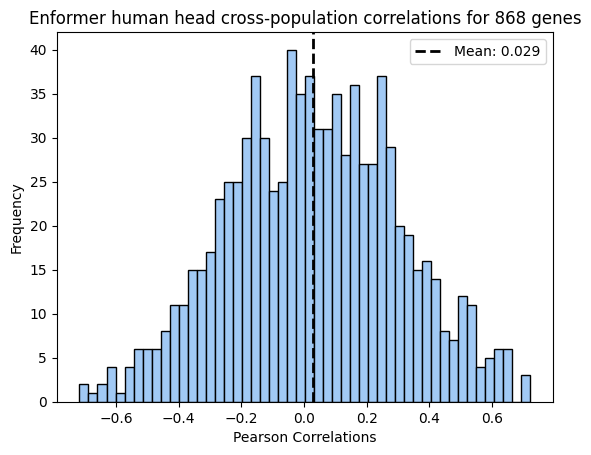

In [8]:
# Plot a histogram
plt.hist(pearson_corr_by_gene["human"], bins=50, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
plt.title('Enformer human head cross-population correlations for 868 genes')
plt.xlabel('Pearson Correlations')
plt.ylabel('Frequency')
mean = np.mean(pearson_corr_by_gene["human"])
plt.axvline(mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
plt.legend()

# Display the plot
plt.show()


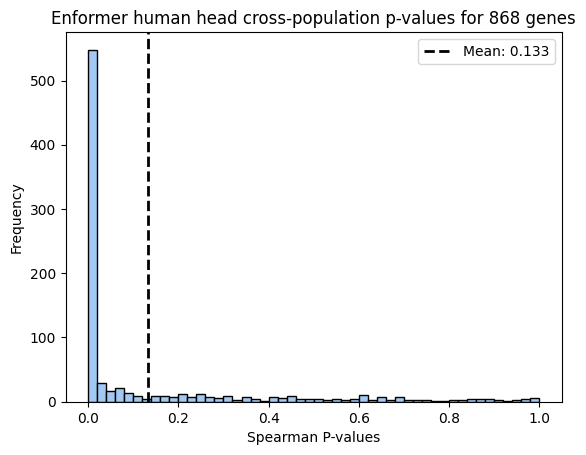

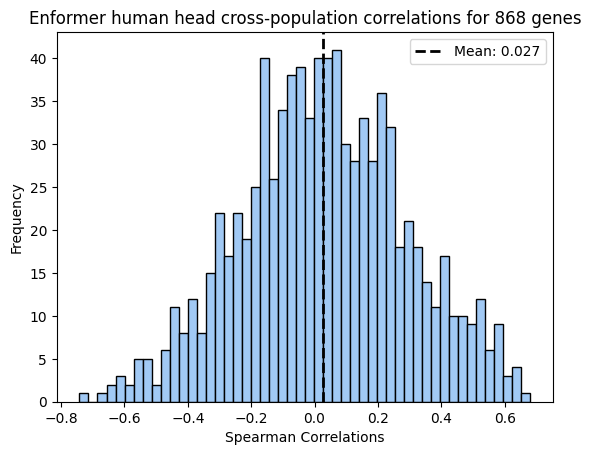

In [32]:
# Plot a histogram
plt.hist(spearman_corr_human["p"], bins=50, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
plt.title('Enformer human head cross-population correlations for 868 genes')
plt.xlabel('Spearman Correlations')
plt.ylabel('Frequency')
mean = np.mean(spearman_corr_human["pval"])
plt.axvline(mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
plt.legend()
# Display the plot
plt.show()

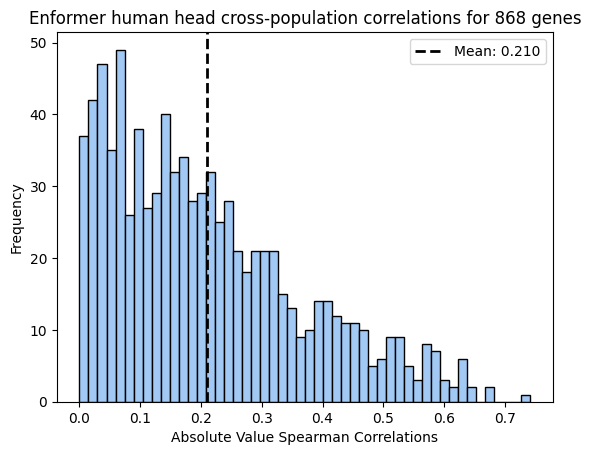

In [37]:
# Plot a histogram
plt.hist(spearman_corr_by_gene["human"].abs(), bins=50, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
plt.title('Enformer human head cross-population correlations for 868 genes')
plt.xlabel('Absolute Value Spearman Correlations')
plt.ylabel('Frequency')
mean = np.mean(spearman_corr_by_gene["human"].abs())
plt.axvline(mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
plt.legend()
# Display the plot
plt.show()

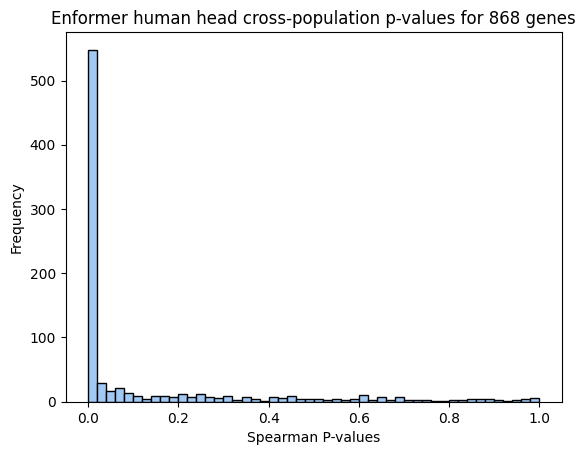

In [79]:
# Plot a histogram
plt.hist(spearman_corr_human['pvalue'], bins=50, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
plt.title('Enformer human head cross-population p-values for 868 genes')
plt.xlabel('Spearman P-values')
plt.ylabel('Frequency')
# Display the plot
plt.show()

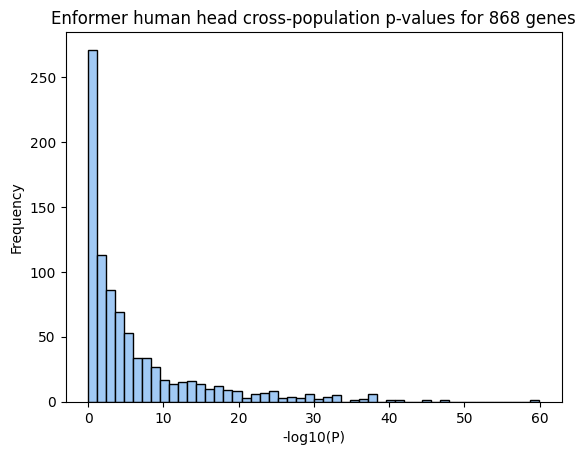

In [9]:
x = []
for pval in spearman_corr_human['pvalue']:
    x.append(-np.log10(pval))
# Plot a histogram
plt.hist(x, bins=50, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
plt.title('Enformer human head cross-population p-values for 868 genes')
plt.xlabel('-log10(P)')
plt.ylabel('Frequency')

# Display the plot
plt.show()


#### Mouse Head Plots

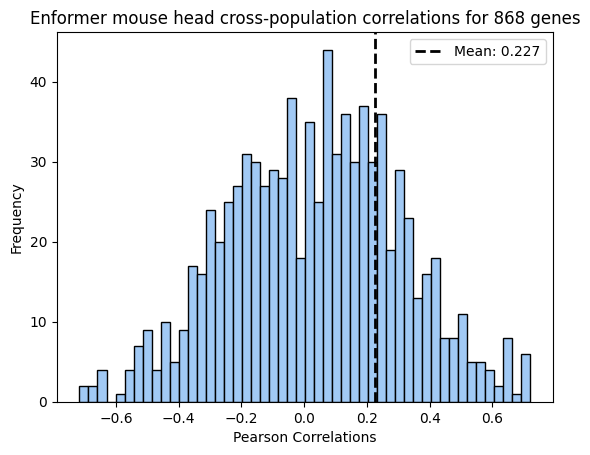

In [38]:
# Plot a histogram
plt.hist(pearson_corr_by_gene["mouse"], bins=50, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
plt.title('Enformer mouse head cross-population correlations for 868 genes')

plt.xlabel('Pearson Correlations')
plt.ylabel('Frequency')

mean = np.mean(pearson_corr_by_gene["mouse"])
plt.axvline(mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
plt.legend()

# Display the plot
plt.show()

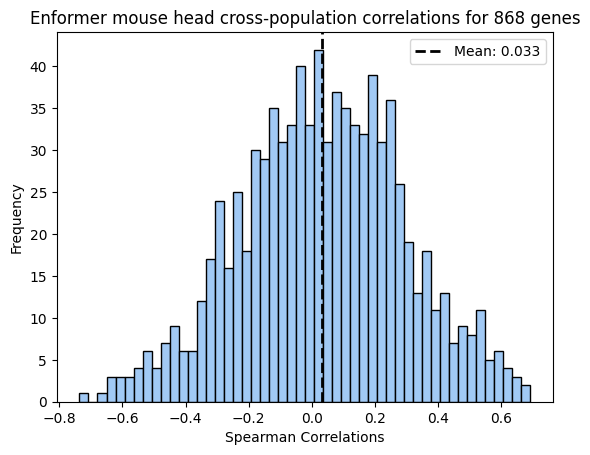

In [34]:
# Plot a histogram
plt.hist(spearman_corr_by_gene["mouse"], bins=50, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
plt.title('Enformer mouse head cross-population correlations for 868 genes')
plt.xlabel('Spearman Correlations')
plt.ylabel('Frequency')
mean = np.mean(spearman_corr_by_gene["mouse"])
plt.axvline(mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
plt.legend()
# Display the plot
plt.show()

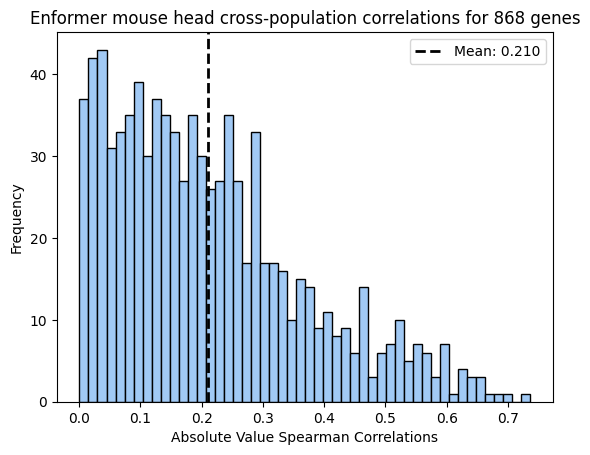

In [39]:
# Plot a histogram
plt.hist(spearman_corr_by_gene["mouse"].abs(), bins=50, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
plt.title('Enformer mouse head cross-population correlations for 868 genes')
plt.xlabel('Absolute Value Spearman Correlations')
plt.ylabel('Frequency')
mean = np.mean(spearman_corr_by_gene["human"].abs())
plt.axvline(mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
plt.legend()
# Display the plot
plt.show()

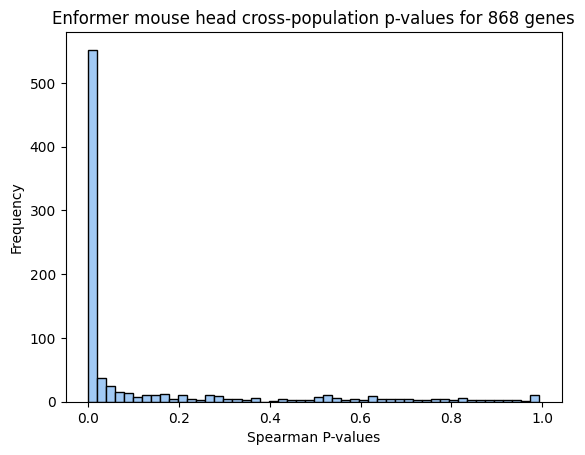

In [80]:
# Plot a histogram
plt.hist(spearman_corr_mouse['pvalue'], bins=50, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
plt.title('Enformer mouse head cross-population p-values for 868 genes')
plt.xlabel('Spearman P-values')
plt.ylabel('Frequency')
# Display the plot
plt.show()

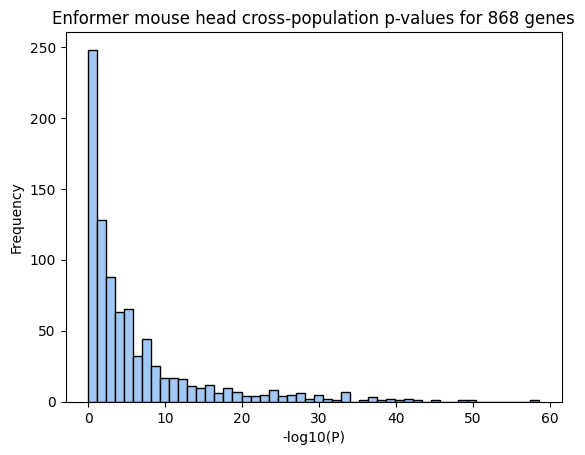

In [75]:
x = []
for pval in spearman_corr_mouse['pvalue']:
    x.append(-np.log10(pval))
# Plot a histogram
plt.hist(x, bins=50, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
plt.title('Enformer mouse head cross-population p-values for 868 genes')
plt.xlabel('-log10(P)')
plt.ylabel('Frequency')

# Display the plot
plt.show()

### Compare Human and Mouse Model Correlations

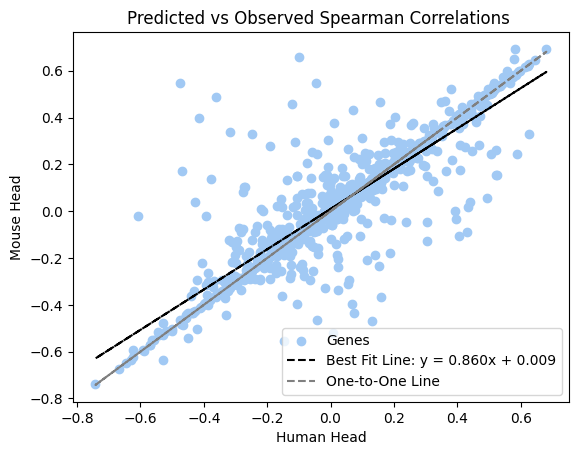

In [39]:
# Fit a linear regression line to the data (calculate slope)
x = spearman_corr_by_gene["human"].values
y = spearman_corr_by_gene["mouse"].values
slope, intercept = np.polyfit(x, y, 1)
# Create the plot
plt.scatter(x, y, label='Genes', marker='o', color=colors[0])
plt.plot(x, slope * x + intercept, '--', color="black", label=f'Best Fit Line: y = {slope:.3f}x + {intercept:.3f}')
plt.plot(x, x, '--', color="grey", label=f'One-to-One Line')
plt.title("Predicted vs Observed Spearman Correlations ")
# Add labels and legend
plt.xlabel('Human Head')
plt.ylabel('Mouse Head')
plt.legend()

# Show the plot
plt.show()

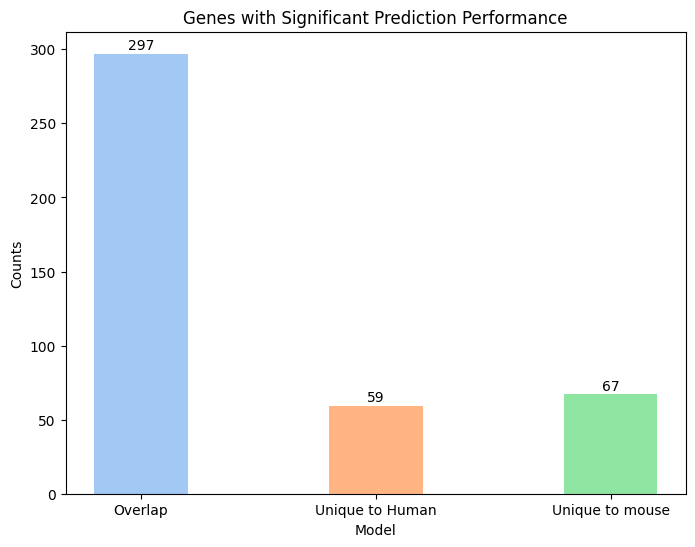

In [54]:
human_sign_genes = spearman_pval_by_gene.index[spearman_pval_by_gene["human"] < 0.05/868]
mouse_sign_genes = spearman_pval_by_gene.index[spearman_pval_by_gene["mouse"] < 0.05/868]
human_unique = human_sign_genes.difference(mouse_sign_genes)
mouse_unique = mouse_sign_genes.difference(human_sign_genes)
overlap = human_sign_genes.intersection(mouse_sign_genes)
# Data for the bar chart
categories = ['Overlap', 'Unique to Human', 'Unique to mouse']
counts = [len(overlap), len(human_unique), len(mouse_unique)]

# Create the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, counts, color=colors, width=0.4)
plt.xlabel('Model')
plt.ylabel('Counts')
plt.title('Genes with Significant Prediction Performance')

# Add numbers over each bar
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, str(count), ha='center', va='bottom')

plt.show()

### Plot Predicted vs Observed Expression

First, we'll plot the best and worst genes, and then a random sample.

In [10]:
def plot_pearson_corr(gene):
    corr = pearson_corr_by_gene.loc[gene]["human"]
    plt.scatter(expr_dict[gene]["observed"], expr_dict[gene]["human predicted"], marker='o', color=colors[0], label=f"Correlation: {corr:.3f}")

    # Add labels and title
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    plt.title(gene)

    # Show the plot
    plt.legend()
    plt.show()

def plot_spearman_corr(gene):
    x = expr_dict[gene]["observed"]
    y = expr_dict[gene]["human predicted"]
    corr, pval = stats.spearmanr(x, y)
    #plt.scatter(x, y, marker='o', color='blue', label=f"Correlation: {corr:.3f}\nP-value: {pval}")
    plt.scatter(stats.rankdata(x), stats.rankdata(y), marker='o', color=colors[1], label=f"Correlation: {corr:.3f}")

    # Add labels and title
    plt.xlabel('Observed Ranks')
    plt.ylabel('Predicted Ranks')
    plt.title(gene)

    # Show the plot
    plt.legend()
    plt.show()

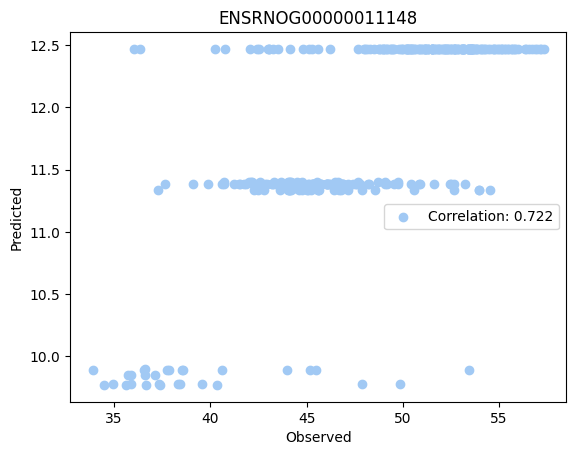

In [14]:
gene = pearson_corr_by_gene["human"].idxmax()
plot_pearson_corr(gene)

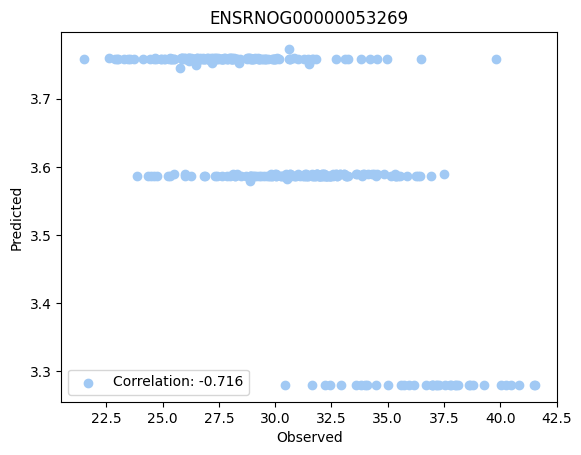

In [12]:
gene = pearson_corr_by_gene["human"].idxmin()
plot_pearson_corr(gene)

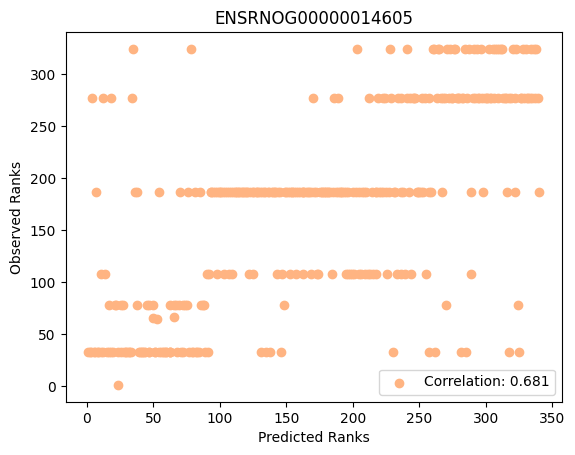

In [51]:
gene = spearman_corr_by_gene["human"].idxmax()
plot_spearman_corr(gene)

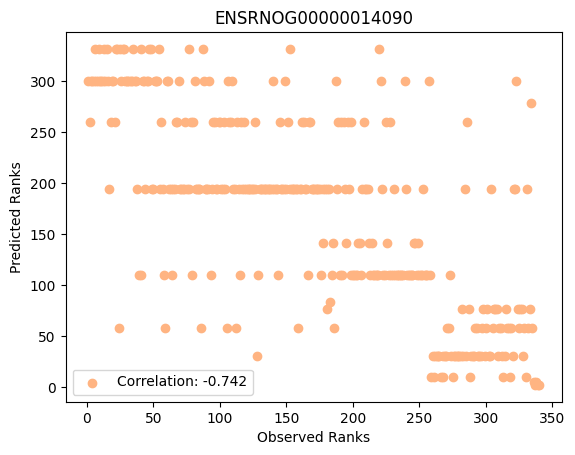

In [15]:
gene = spearman_corr_by_gene["human"].idxmin()
plot_spearman_corr(gene)

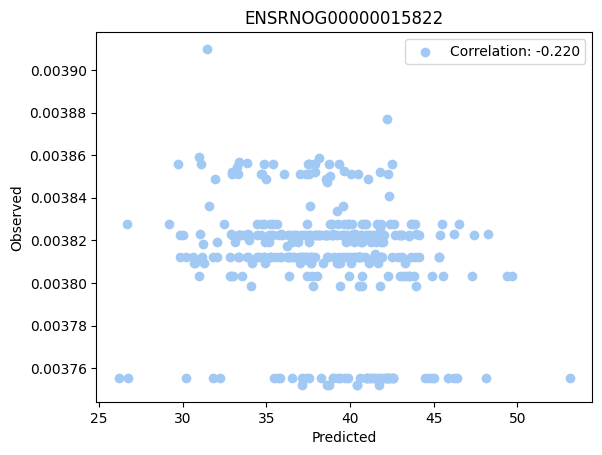

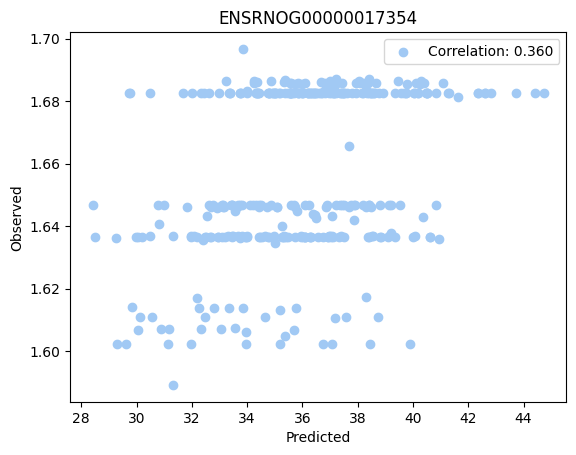

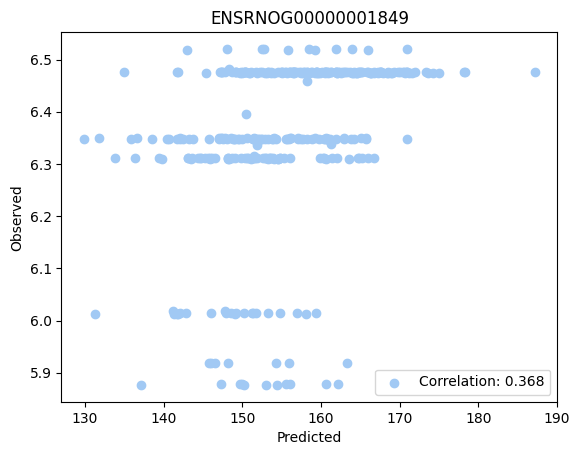

In [53]:
gene_sample = pearson_corr_by_gene.sample(n=3).index
for gene in gene_sample:
    plot_pearson_corr(gene)